In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
nn = tf.keras.models.Sequential([
    tf.keras.layers.Input((1,)),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(1)
])

In [3]:
optimal = tf.keras.optimizers.Adam(learning_rate=0.001)

In [4]:
def odd_system(t, net):
    t = t.reshape(-1, 1)
    t = tf.constant(t, dtype=tf.float32)
    t_0 = tf.zeros((1,1))
    one = tf.ones((1,1))

    with tf.GradientTape() as tape:
        tape.watch(t)
        u = net(t)
        u_t = tape.gradient(u, t)

    ode_loss = u_t - tf.math.cos(2*np.pi*t)
    IC_loss = net(t_0) - one

    sqare_loss = tf.square(ode_loss) + tf.square(IC_loss)
    total_loss = tf.reduce_mean(sqare_loss)

    return total_loss

In [5]:
train_t = (np.random.rand(50)*2).reshape(-1,1)
train_loss_record = []

for itr in range(6000):
    with tf.GradientTape() as tape:
        train_loss = odd_system(train_t, nn)
        train_loss_record.append(train_loss)

        grad_w = tape.gradient(train_loss, nn.trainable_variables)
        optimal.apply_gradients(zip(grad_w, nn.trainable_variables))

In [6]:
test_t = (np.random.rand(50) * 2).reshape(-1, 1)

In [7]:
predictions = nn.predict(test_t)

2/2 [==============================] - 0s 1ms/step


In [8]:
def true_sol(t):
    return np.sin(2*np.pi*t)/(2*np.pi) + 1

In [9]:
import seaborn as sns

In [10]:
sort_val = np.sort(test_t.reshape(1,-1))

In [11]:
cur = np.arange(0, 2, 0.01)

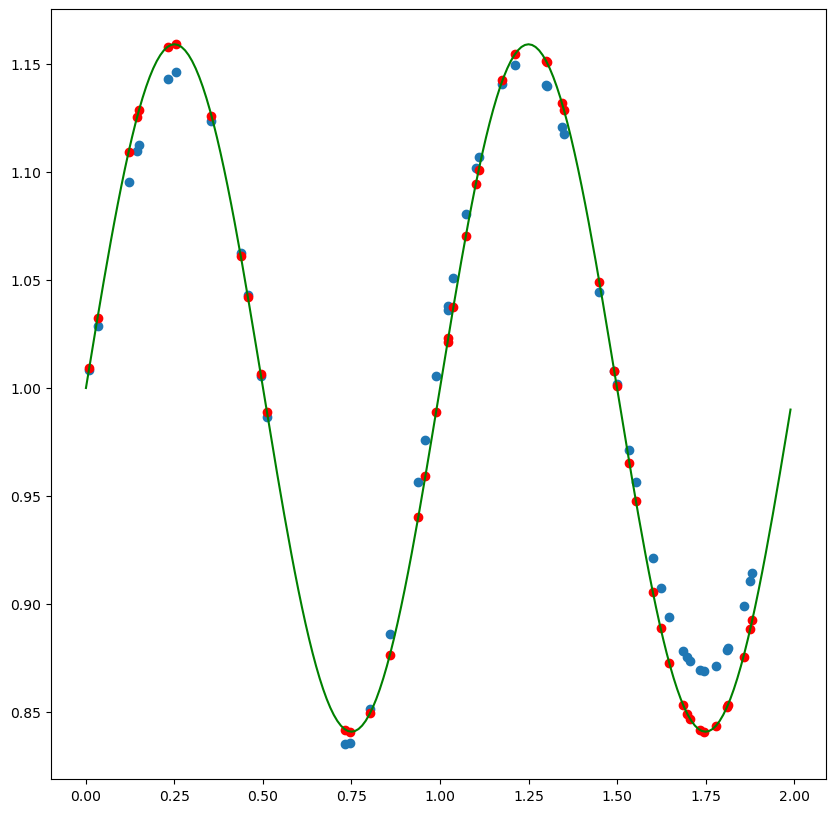

In [12]:
plt.figure(figsize=(10, 10))
plt.scatter(test_t, predictions)
plt.scatter(test_t, [true_sol(i) for i in test_t]  , color='red')
plt.plot(cur, [true_sol(i) for i in cur], color='green')
plt.show()

In [13]:
from function import *

In [14]:
df = make_data(dt=0.01, total_time = 50)

In [15]:
df

,u,time,f
0,0.000000e+00,0.00,0.000000
1,6.279052e-02,0.01,0.152729
2,1.253332e-01,0.02,0.272857
3,1.873813e-01,0.03,0.369560
4,2.486899e-01,0.04,0.449713
...,...,...,...
4996,-2.486899e-01,49.96,0.299277
4997,-1.873813e-01,49.97,0.338483
4998,-1.253332e-01,49.98,0.375216
4999,-6.279052e-02,49.99,0.410140


In [16]:
train = df.iloc[:int(len(df)*0.8)]
test = df.iloc[int(len(df)*0.8):]

In [17]:
train_x = train.iloc[:, :2].values
train_y = train.iloc[:, 2].values
test_x = test.iloc[:, :2].values
test_y = test.iloc[:, 2].values

In [18]:
train_x = tf.cast(train_x, dtype=tf.float32)

In [19]:
inputs = tf.keras.Input(shape=(2,))
x = tf.keras.layers.Dense(32, activation='sigmoid')(inputs)
z_pred = tf.keras.layers.Dense(1, name='z_pred')(x)
f_pred = tf.keras.layers.Dense(1, name='f_pred')(x)
nn_2 = tf.keras.Model(inputs=inputs, outputs=[z_pred, f_pred])


In [20]:
A = tf.constant(3, dtype=tf.float32)  
B = tf.constant(5, dtype=tf.float32)  
G = tf.constant(1, dtype=tf.float32)  
n = tf.constant(1, dtype=tf.float32)

In [21]:
def bouc_wen(u, net, A, B, G, z, n):
    with tf.GradientTape() as tape:
        tape.watch(u)
        z_pred, f_pred = net(u)
    
    Z_dot_pred = tape.gradient(z_pred, u)
    Z_dot_pred = tf.cast(Z_dot_pred, dtype=tf.float32)
    f_pred = tf.cast(f_pred, dtype=tf.float32)
    
    # Assuming compute_boucwen_dynamics returns the true_function
    true_function = compute_boucwen_dynamics(u, z, A, B, G, n)
    true_function = tf.cast(true_function, dtype=tf.float32)
    
    # Compute loss
    physics_loss = tf.reduce_mean(tf.square(true_function - f_pred))
    data_loss = tf.reduce_mean(tf.square(train_y - f_pred))
    total_loss = 0.5 * physics_loss + 0.5 * data_loss

    return total_loss


In [22]:
u_diff = np.diff(train_x[:,0])

In [23]:
t_diff = np.diff(train_x[:,1])

In [24]:
[u_diff, t_diff]

[array([0.06279052, 0.06254271, 0.06204808, ..., 0.06130858, 0.06204808,
        0.06254271], dtype=float32),
 array([0.01      , 0.01      , 0.01      , ..., 0.01000214, 0.00999832,
        0.01000214], dtype=float32)]

In [25]:
train_y[:3999]

array([0.        , 0.15272865, 0.27285674, ..., 0.29948548, 0.33863693,
       0.3753289 ])

In [26]:
train_y

array([0.        , 0.15272865, 0.27285674, ..., 0.33863693, 0.3753289 ,
       0.41022182])

In [28]:
optimal = tf.keras.optimizers.Adam(learning_rate=0.001)
optimal.build(nn_2.trainable_variables)

train_loss_record_2 = []
for itr in range(500):
    with tf.GradientTape() as tape:
        train_loss = bouc_wen(train_x, nn_2, A, B, G, tf.constant(1, dtype = tf.float32), n)
        train_loss_record_2.append(train_loss)

        grad_w = tape.gradient(train_loss, nn_2.trainable_variables)
        optimal.apply_gradients(zip(grad_w, nn_2.trainable_variables))


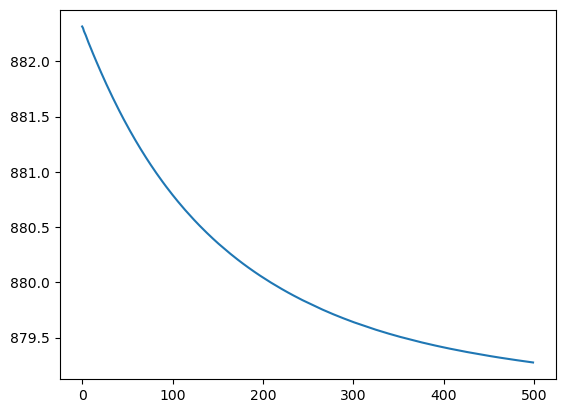

In [29]:
plt.plot(train_loss_record_2)

In [30]:
pred_2 = nn_2.predict(test_x)

32/32 [==============================] - 0s 581us/step


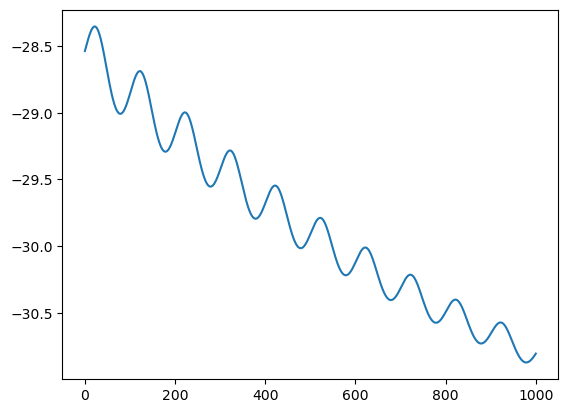

In [31]:
plt.plot(pred_2[1])

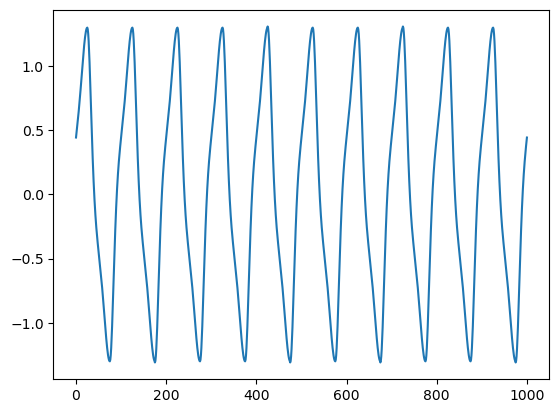

In [32]:
plt.plot(test_y)

In [38]:
import deepxde as dde
from scipy.io import loadmat
import re

In [39]:
def load_training_data(num):
    data = loadmat("./deepxde-master/examples/dataset/cylinder_nektar_wake.mat")
    U_star = data["U_star"]  # N x 2 x T
    P_star = data["p_star"]  # N x T
    t_star = data["t"]  # T x 1
    X_star = data["X_star"]  # N x 2
    N = X_star.shape[0]
    T = t_star.shape[0]
    # Rearrange Data
    XX = np.tile(X_star[:, 0:1], (1, T))  # N x T
    YY = np.tile(X_star[:, 1:2], (1, T))  # N x T
    TT = np.tile(t_star, (1, N)).T  # N x T
    UU = U_star[:, 0, :]  # N x T
    VV = U_star[:, 1, :]  # N x T
    PP = P_star  # N x T
    x = XX.flatten()[:, None]  # NT x 1
    y = YY.flatten()[:, None]  # NT x 1
    t = TT.flatten()[:, None]  # NT x 1
    u = UU.flatten()[:, None]  # NT x 1
    v = VV.flatten()[:, None]  # NT x 1
    p = PP.flatten()[:, None]  # NT x 1
    # training domain: X × Y = [1, 8] × [−2, 2] and T = [0, 7]
    data1 = np.concatenate([x, y, t, u, v, p], 1)
    data2 = data1[:, :][data1[:, 2] <= 7]
    data3 = data2[:, :][data2[:, 0] >= 1]
    data4 = data3[:, :][data3[:, 0] <= 8]
    data5 = data4[:, :][data4[:, 1] >= -2]
    data_domain = data5[:, :][data5[:, 1] <= 2]
    # choose number of training points: num =7000
    idx = np.random.choice(data_domain.shape[0], num, replace=False)
    x_train = data_domain[idx, 0:1]
    y_train = data_domain[idx, 1:2]
    t_train = data_domain[idx, 2:3]
    u_train = data_domain[idx, 3:4]
    v_train = data_domain[idx, 4:5]
    p_train = data_domain[idx, 5:6]
    return [x_train, y_train, t_train, u_train, v_train, p_train]

# Parameters to be identified
C1 = dde.Variable(0.0)
C2 = dde.Variable(0.0)

In [40]:
# true values
C1true = 1.0
C2true = 0.01

In [41]:
# Define Navier Stokes Equations (Time-dependent PDEs)
def Navier_Stokes_Equation(x, y):
    u = y[:, 0:1]
    v = y[:, 1:2]
    p = y[:, 2:3]
    du_x = dde.grad.jacobian(y, x, i=0, j=0)
    du_y = dde.grad.jacobian(y, x, i=0, j=1)
    du_t = dde.grad.jacobian(y, x, i=0, j=2)
    dv_x = dde.grad.jacobian(y, x, i=1, j=0)
    dv_y = dde.grad.jacobian(y, x, i=1, j=1)
    dv_t = dde.grad.jacobian(y, x, i=1, j=2)
    dp_x = dde.grad.jacobian(y, x, i=2, j=0)
    dp_y = dde.grad.jacobian(y, x, i=2, j=1)
    du_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
    dv_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)
    continuity = du_x + dv_y
    x_momentum = du_t + C1 * (u * du_x + v * du_y) + dp_x - C2 * (du_xx + du_yy)
    y_momentum = dv_t + C1 * (u * dv_x + v * dv_y) + dp_y - C2 * (dv_xx + dv_yy)
    return [continuity, x_momentum, y_momentum]

In [42]:
Lx_min, Lx_max = 1.0, 8.0
Ly_min, Ly_max = -2.0, 2.0
# Spatial domain: X × Y = [1, 8] × [−2, 2]
space_domain = dde.geometry.Rectangle([Lx_min, Ly_min], [Lx_max, Ly_max])
# Time domain: T = [0, 7]
time_domain = dde.geometry.TimeDomain(0, 7)
# Spatio-temporal domain
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

# Get the training data: num = 7000
[ob_x, ob_y, ob_t, ob_u, ob_v, ob_p] = load_training_data(num=7000)
ob_xyt = np.hstack((ob_x, ob_y, ob_t))
observe_u = dde.icbc.PointSetBC(ob_xyt, ob_u, component=0)
observe_v = dde.icbc.PointSetBC(ob_xyt, ob_v, component=1)

In [43]:
# Training datasets and Loss
data = dde.data.TimePDE(
    geomtime,
    Navier_Stokes_Equation,
    [observe_u, observe_v],
    num_domain=700,
    num_boundary=200,
    num_initial=100,
    anchors=ob_xyt,
)

In [44]:
# Neural Network setup
layer_size = [3] + [50] * 6 + [3]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)
model = dde.Model(data, net)

# callbacks for storing results
fnamevar = "variables.dat"
variable = dde.callbacks.VariableValue([C1, C2], period=100, filename=fnamevar)

In [46]:
model.compile("adam", lr=0.001, external_trainable_variables=[C1, C2])
loss_history, train_state = model.train(
    iterations=5000, callbacks=[variable], display_every=1000, disregard_previous_best=True
)

Compiling model...
'compile' took 0.886213 s

Training model...

1779      [4.75e-04, 6.12e-04, 6.74e-04, 1.45e-03, 2.69e-03]    [4.75e-04, 6.12e-04, 6.74e-04, 1.45e-03, 2.69e-03]    []  
2000      [3.83e-04, 4.82e-04, 5.91e-04, 1.35e-03, 2.07e-03]    [3.83e-04, 4.82e-04, 5.91e-04, 1.35e-03, 2.07e-03]    []  
3000      [2.77e-04, 3.73e-04, 3.73e-04, 8.61e-04, 1.29e-03]    [2.77e-04, 3.73e-04, 3.73e-04, 8.61e-04, 1.29e-03]    []  
4000      [2.73e-04, 3.51e-04, 3.08e-04, 8.31e-04, 9.41e-04]    [2.73e-04, 3.51e-04, 3.08e-04, 8.31e-04, 9.41e-04]    []  
5000      [1.86e-04, 2.61e-04, 1.69e-04, 4.45e-04, 6.45e-04]    [1.86e-04, 2.61e-04, 1.69e-04, 4.45e-04, 6.45e-04]    []  
6000      [1.56e-04, 2.13e-04, 1.40e-04, 3.38e-04, 4.90e-04]    [1.56e-04, 2.13e-04, 1.40e-04, 3.38e-04, 4.90e-04]    []  
6779      [1.28e-04, 1.84e-04, 1.24e-04, 2.78e-04, 3.94e-04]    [1.28e-04, 1.84e-04, 1.24e-04, 2.78e-04, 3.94e-04]    []  

Best model at step 6779:
  train loss: 1.11e-03
  test loss: 1.11e-03
  t

In [47]:
f = model.predict(ob_xyt, operator=Navier_Stokes_Equation)
print("Mean residual:", np.mean(np.absolute(f)))

Mean residual: 0.008508558


In [48]:
f

[array([[-0.01779041],
        [-0.01021512],
        [ 0.00203919],
        ...,
        [-0.00158869],
        [ 0.00679904],
        [ 0.01128291]], dtype=float32),
 array([[-0.00588303],
        [ 0.0134867 ],
        [-0.00428008],
        ...,
        [ 0.0061999 ],
        [ 0.02287439],
        [-0.00604503]], dtype=float32),
 array([[ 0.00717664],
        [ 0.00329819],
        [ 0.01243755],
        ...,
        [-0.01020945],
        [ 0.0025637 ],
        [-0.00838139]], dtype=float32)]

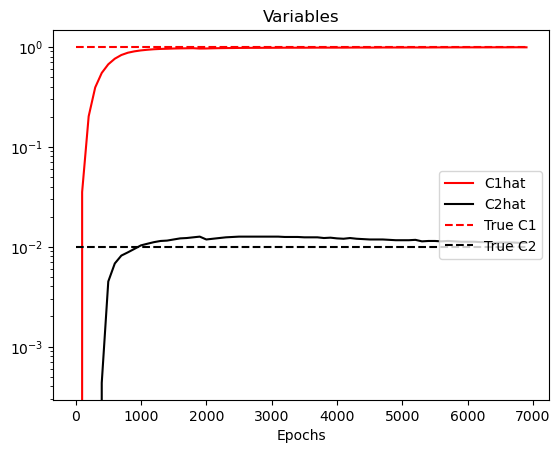

In [52]:
# Plot Variables:
# reopen saved data using callbacks in fnamevar
lines = open(fnamevar, "r").readlines()
# read output data in fnamevar
Chat = np.array(
    [
        np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)
l, c = Chat.shape
plt.semilogy(range(0, l * 100, 100), Chat[:, 0], "r-")
plt.semilogy(range(0, l * 100, 100), Chat[:, 1], "k-")
plt.semilogy(range(0, l * 100, 100), np.ones(Chat[:, 0].shape) * C1true, "r--")
plt.semilogy(range(0, l * 100, 100), np.ones(Chat[:, 1].shape) * C2true, "k--")
plt.legend(["C1hat", "C2hat", "True C1", "True C2"], loc="right")
plt.xlabel("Epochs")
plt.title("Variables")
plt.show()

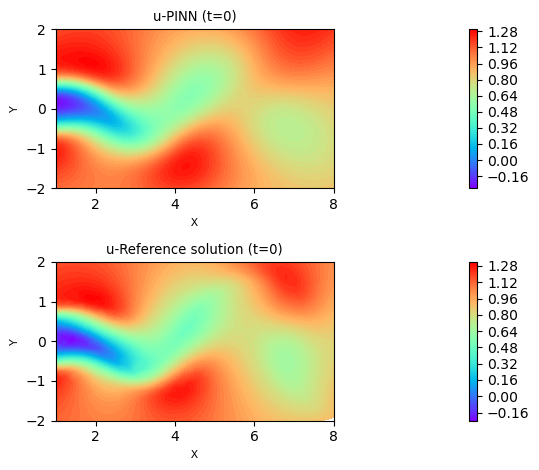

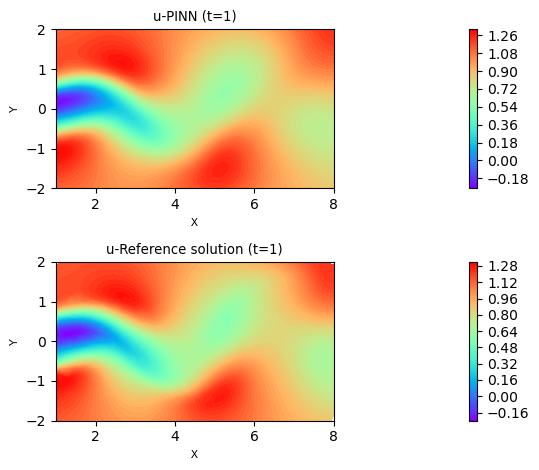

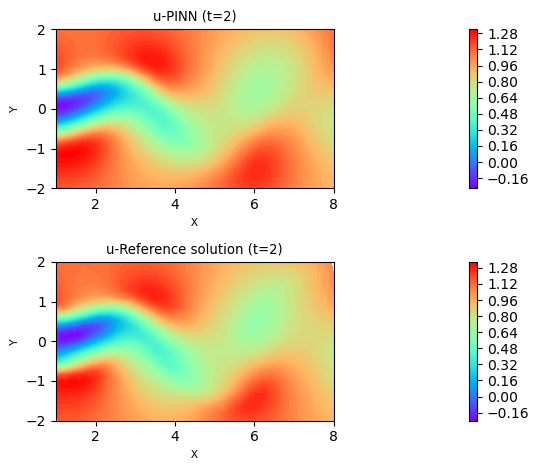

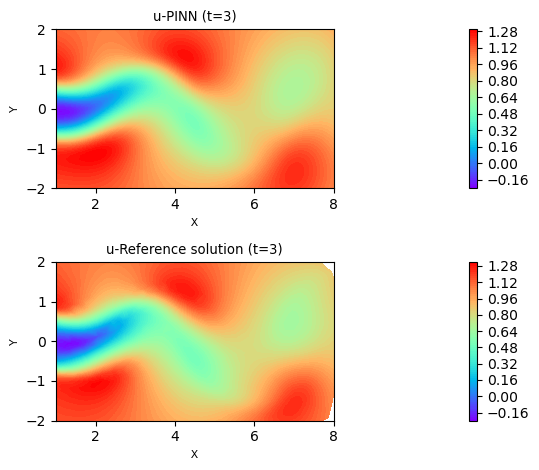

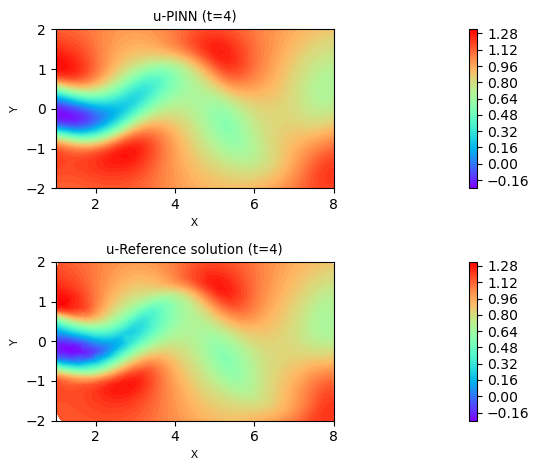

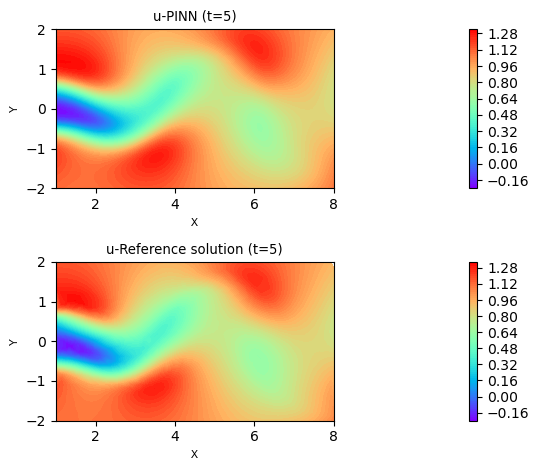

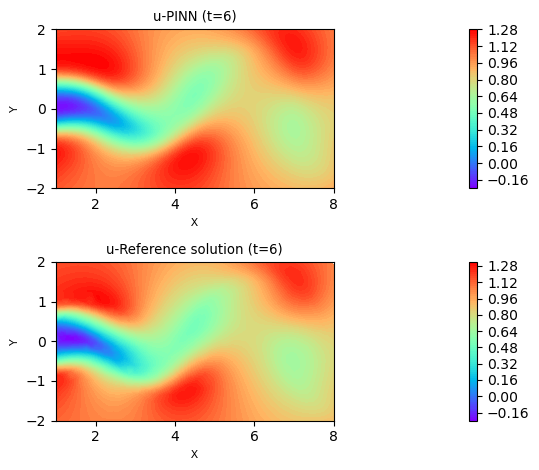

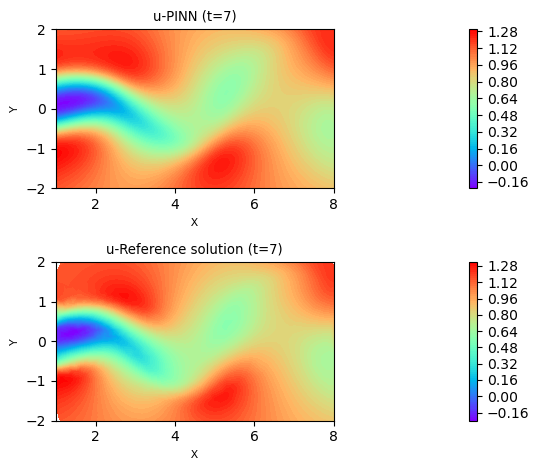

In [53]:
for t in range(0, 8):
    [ob_x, ob_y, ob_t, ob_u, ob_v, ob_p] = load_training_data(num=140000)
    xyt_pred = np.hstack((ob_x, ob_y, t * np.ones((len(ob_x), 1))))
    uvp_pred = model.predict(xyt_pred)
    x_pred, y_pred, t_pred = xyt_pred[:, 0], xyt_pred[:, 1], xyt_pred[:, 2]
    u_pred, v_pred, p_pred = uvp_pred[:, 0], uvp_pred[:, 1], uvp_pred[:, 2]
    x_true = ob_x[ob_t == t]
    y_true = ob_y[ob_t == t]
    u_true = ob_u[ob_t == t]
    fig, ax = plt.subplots(2, 1)
    cntr0 = ax[0].tricontourf(x_pred, y_pred, u_pred, levels=80, cmap="rainbow")
    cb0 = plt.colorbar(cntr0, ax=ax[0])
    cntr1 = ax[1].tricontourf(x_true, y_true, u_true, levels=80, cmap="rainbow")
    cb1 = plt.colorbar(cntr1, ax=ax[1])
    ax[0].set_title("u-PINN " + "(t=" + str(t) + ")", fontsize=9.5)
    ax[0].axis("scaled")
    ax[0].set_xlabel("X", fontsize=7.5, family="Arial")
    ax[0].set_ylabel("Y", fontsize=7.5, family="Arial")
    ax[1].set_title("u-Reference solution " + "(t=" + str(t) + ")", fontsize=9.5)
    ax[1].axis("scaled")
    ax[1].set_xlabel("X", fontsize=7.5, family="Arial")
    ax[1].set_ylabel("Y", fontsize=7.5, family="Arial")
    fig.tight_layout()
    plt.show()